In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
load_dotenv()
model = ChatOpenAI()

# Tools

In [69]:
#@tool
def finance_research_tool(topic: str) -> str:
    """
    Search for the finance topic on web using TavilySearch
    """

    tavilly_tool = TavilySearch(max_results=5, topic="finance")
    response = tavilly_tool.invoke({"query": topic})
    return response

#@tool
def general_research_tool(topic: str) -> str:
    """
    Search for the general topic on web using TavilySearch
    """

    tavilly_tool = TavilySearch(max_results=5, topic="general")
    response = tavilly_tool.invoke({"query": topic})
    return response

In [40]:
@tool
def add(a: float, b: float) -> float:
    """Add two numbers."""
    return a + b

@tool
def multiply(a: float, b: float) -> float:
    """Multiply two numbers."""
    return a * b

In [52]:
@tool
def summarize(response: str) -> str:
    """Summarize and returns the response."""
    summary = model.invoke(f"Generate summary of {response} in 300 words.")
    return summary

# Agents

In [71]:
research_agent = create_react_agent(
    model=model,
    tools=[finance_research_tool, general_research_tool],
    name="research_agent",
    prompt="""You are a world class researcher with access to finance_research_tool and general_research_tool.
    For general research, use general_research_tool.
    For finance, use finance_research_tool.
    Do not do any math."""
)

In [72]:
math_agent = create_react_agent(
    model=model,
    tools=[add, multiply],
    name="math_agent",
    prompt="You are a math expert. Always use one tool at a time."
)

In [73]:
summary_agent = create_react_agent(
    model=model,
    tools=[summarize],
    name="summary_agent",
    prompt="You are a summary generator expert."
)

## Mid-Level Supervisors

In [74]:
research_team = create_supervisor(
    [research_agent, math_agent],
    model=model,
    prompt="""
    You are the research supervisor managing two specialized agents: research_agent and math_agent.
    DO NOT answer user queries yourself.

    Your tasks:
    1. Route general (non-math) queries to research_agent.
    2. When the research_agent returns data that requires numeric calculations (like totals or sums), parse the relevant numbers from the response.
    3. Formulate math queries to the math_agent to compute the required sums step-by-step.
    4. Collect math_agent’s results and combine them if necessary.
    5. Pass the final processed answer to the top_level_supervisor.

    Always use the math_agent for any numeric calculations, do not calculate yourself.
    """,
    supervisor_name="research_supervisor"
).compile(name="research_team")

# Top Level Supervisor

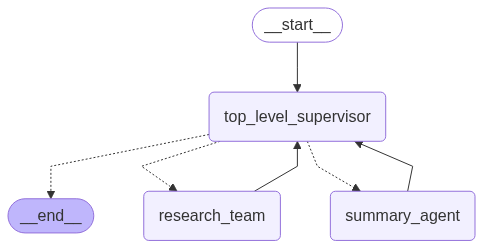

In [78]:
top_level_supervisor = create_supervisor(
    [research_team, summary_agent],
    model=model,
    prompt="""
    You are the top-level supervisor overseeing research_team and summary_agent.
    Delegate tasks to research_team for initial answers.
    Use summary_agent to present the final response.
    """,
    supervisor_name="top_level_supervisor"
).compile(name="top_level_supervisor")

top_level_supervisor

In [79]:
result = top_level_supervisor.invoke({
    "messages": [
        {
            "role": "user",
            "content": "Difference between AI and ML"
        }
    ]
})

Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel is_last_step, ignoring it.
Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel remaining_steps, ignoring it.
Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel is_last_step, ignoring it.
Task top_level_supervisor with path ('__pregel_pull', 'top_level_supervisor') wrote to unknown channel remaining_steps, ignoring it.


In [80]:
result

{'messages': [HumanMessage(content='Difference between AI and ML', additional_kwargs={}, response_metadata={}, id='9105802a-5ef0-466a-8f3f-2ea9cc5962ae'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_xJ3vkrYm2tWH3c9bvhOAVVRA', 'function': {'arguments': '{}', 'name': 'transfer_to_research_team'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 105, 'total_tokens': 118, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BowzZoYhBScsO84N2R07uaMX1bAwG', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='top_level_supervisor', id='run--5ad76ff1-aac5-42bd-b92a-aa93a07b8cec-0', tool_calls=[{'name': 'transfer_to_research_team', 'args': {}